In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Requires TensorFlow version 1.13.1 and Keras 2.1.0

In [6]:
!sudo pip install --no-deps tensorflow==1.13.1
!sudo pip install --no-deps keras==2.1.0

     |████████████████████████████████| 307kB 4.2MB/s 
  Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0


In [3]:
!pip install h5py==2.8.0

In [3]:
!pip install keras_applications

     |████████████████████████████████| 51kB 2.7MB/s 
ERROR: tensorflow 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 2.4.0 which is incompatible.
ERROR: tensorflow 1.13.1 has requirement tensorflow-estimator<1.14.0rc0,>=1.13.0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.


## Clone the Repo

In [4]:
!git clone https://github.com/matterport/Mask_RCNN.git /content/gdrive/My\Drive/ml_project

Cloning into '/content/gdrive/MyDrive/ml_project/set_up_maskrcnn'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Checking out files: 100% (76/76), done.


In [5]:
%cd /content/gdrive/My\Drive/ml_project/set_up_maskrcnn/

/content/gdrive/MyDrive/ml_project/set_up_maskrcnn


In [6]:
%pwd

'/content/gdrive/MyDrive/ml_project/set_up_maskrcnn'

In [7]:
%ls

assets/  images/      mask_rcnn_coco.h5    README.md         setup.cfg
build/   LICENSE      mask_rcnn.egg-info/  requirements.txt  setup.py
dist/    MANIFEST.in  mrcnn/               samples/


## Install the Mask R-CNN Library

In [15]:
!python /content/gdrive/My\Drive/ml_project/set_up_maskrcnn/setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mr

## Confirm the Library Was Installed

In [8]:
!	pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


## Prepare the model


In [9]:
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import os

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Create the inference object

In [14]:
from mrcnn.config import Config

class InferenceConfig(Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME='coco'
    NUM_CLASSES = 1 + 80

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [15]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [16]:
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [23]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Prediction and Visualization

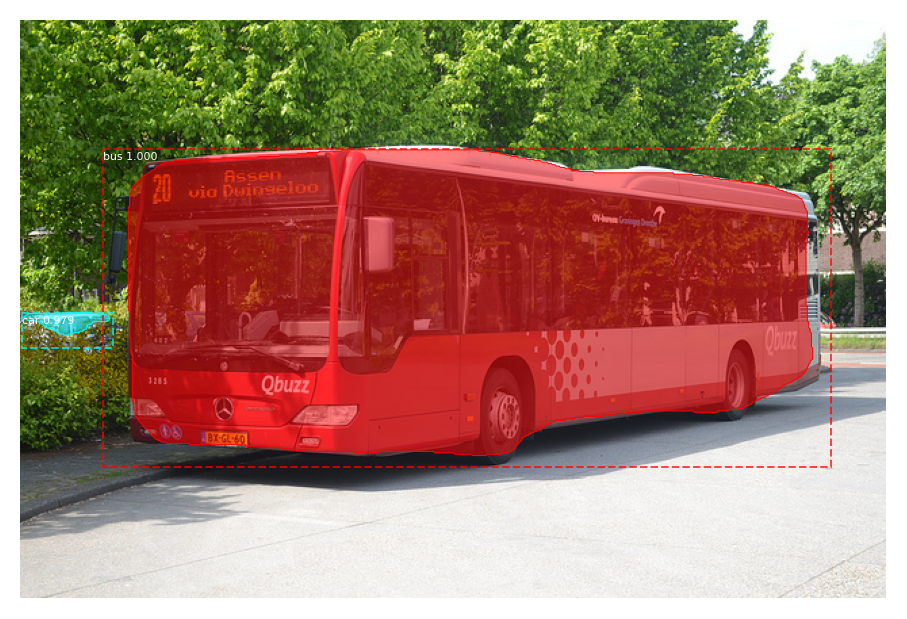

In [24]:
path = '/content/gdrive/My Drive/ml_project/set_up_maskrcnn/images/8829708882_48f263491e_z.jpg'
image = skimage.io.imread(path)

# Run detection
results = model.detect([image], verbose=0)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Background Removal

In [21]:
def segment(image, r):
  idx = r['scores'].argmax()
  mask = r['masks'][:,:,idx]
  mask = np.stack((mask,)*3, axis=-1)
  mask = mask.astype('uint8')
  bg = 255 - mask * 255
  mask_img = image*mask
  result = mask_img+ bg
  return result

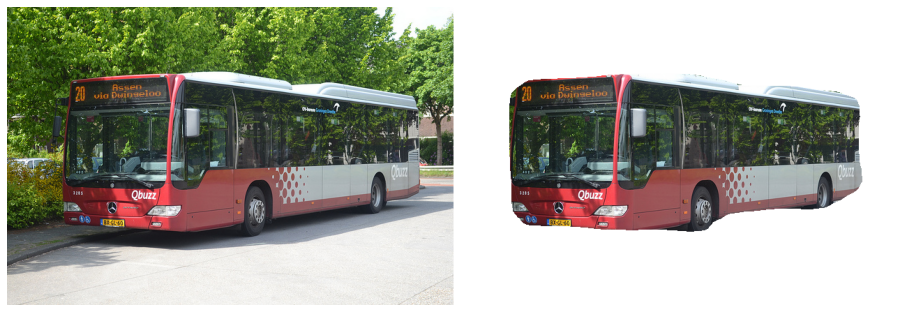

In [22]:
segmentation = segment(image, r)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image, segmentation], axis = 1))

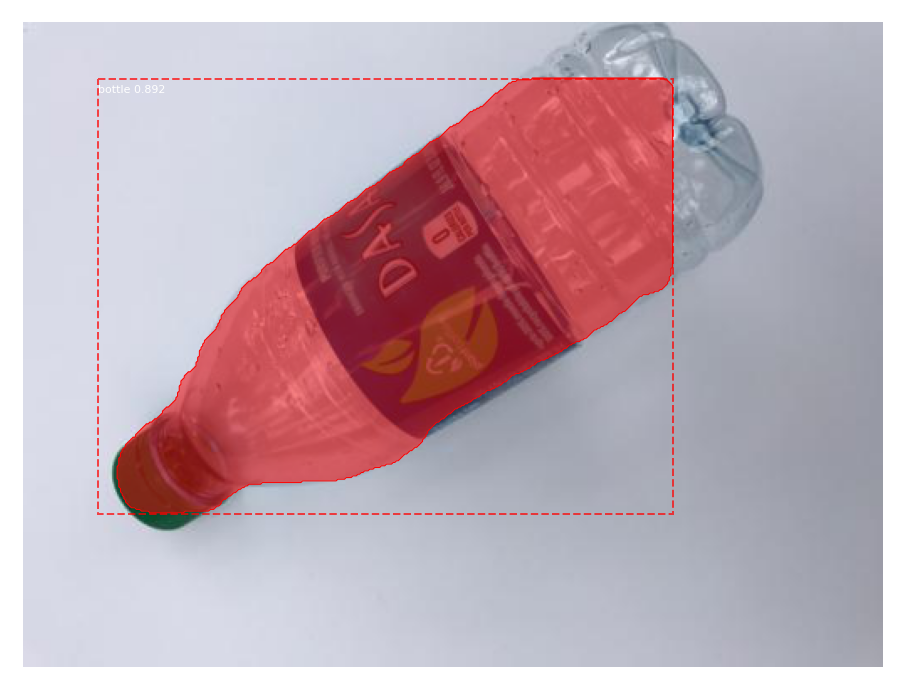

In [31]:
image2 = skimage.io.imread('/content/gdrive/My Drive/ml_project/set_up_maskrcnn/images/plastic14.jpg')

# Run detection
results2 = model.detect([image2], verbose=0)

# Visualize results
r2 = results2[0]
visualize.display_instances(image2, r2['rois'], r2['masks'], r2['class_ids'], 
                            class_names, r2['scores'])

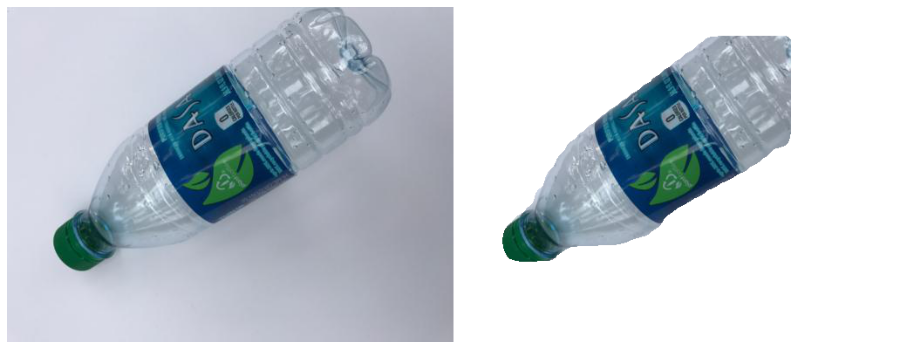

In [32]:
segmentation2 = segment(image2, r2)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image2, segmentation2], axis = 1))

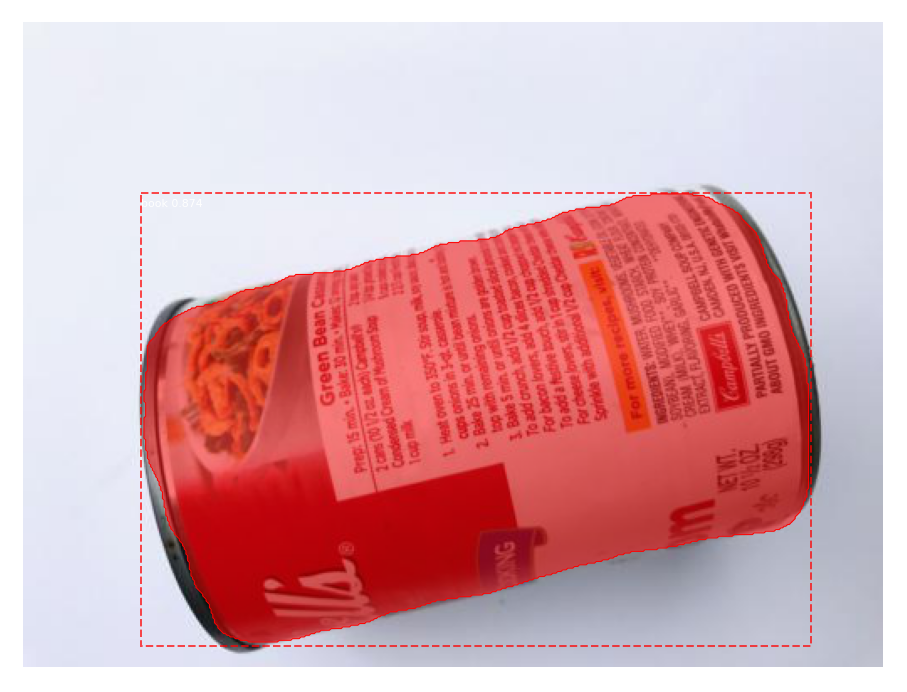

In [33]:
image3 = skimage.io.imread('/content/gdrive/My Drive/ml_project/set_up_maskrcnn/images/metal143.jpg')

# Run detection
results3 = model.detect([image3], verbose=0)

# Visualize results
r3 = results3[0]
visualize.display_instances(image3, r3['rois'], r3['masks'], r3['class_ids'], 
                            class_names, r3['scores'])

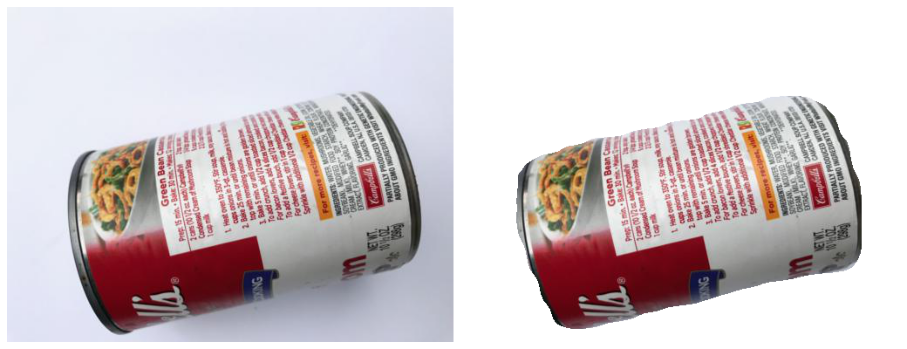

In [34]:
segmentation3 = segment(image3, r3)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image3, segmentation3], axis = 1))